In [1]:
import numpy as np
import matplotlib.pyplot as plt
import l63vda

In [4]:
nexp = 81
p, r, b, dt, nstop = 10.0, 32.0, 8/3, 0.01, 10000
w0 = np.loadtxt(f"i01.txt")
np.savetxt(f"i{nexp:02}.txt", w0)
param = p, r, b, dt, nstop
_ = l63vda.gen_true(nexp, param)
w = np.load(f"m{nexp:02}c000.npy")

In [5]:
w.shape

(10001, 3)

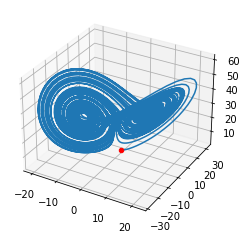

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*w[0,:], c="red")
ax.plot(*w.transpose())

# Artificial neural network

## Construction

In [12]:
dwdt = (w[1:] - w[:-1]) / dt

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

nn = make_pipeline(StandardScaler(), MLPRegressor())

## Learning

In [20]:
nn.fit(w[1:], dwdt)

/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor())])

## Quick check

In [39]:
w0  + dt * nn.predict(w0[None,])

array([[1.17501477, 3.22572897, 4.92990392]])

In [128]:
w[1,]

array([1.2       , 3.24      , 4.89666667])

## True vs estimated tendencies

In [76]:
dwdt_nn = nn.predict(w[0:-1])

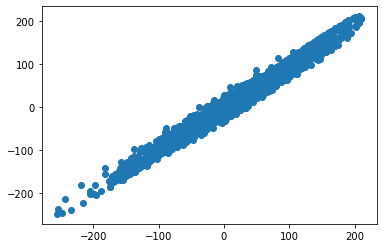

In [77]:
fig, ax = plt.subplots()
ax.scatter(dwdt[:, 0], dwdt_nn[:, 0])

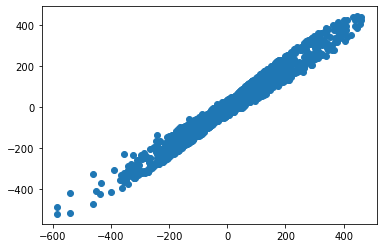

In [78]:
fig, ax = plt.subplots()
ax.scatter(dwdt[:, 1], dwdt_nn[:, 1])

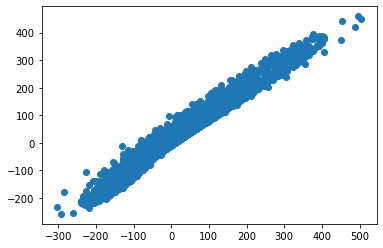

In [79]:
fig, ax = plt.subplots()
ax.scatter(dwdt[:, 2], dwdt_nn[:, 2])

# Forecast with the neural network model

## Old interface: `odeint`

In [121]:
from scipy.integrate import odeint

def florenz_nn(x, args):
    return nn.predict(x[None,]).ravel()

w_nn = odeint(florenz_nn, w0, np.linspace(0, 100, 10001))

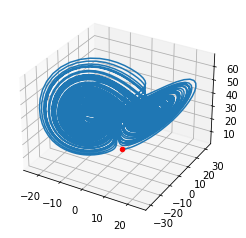

In [122]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*w0, c="red")
ax.plot(*w_nn.transpose())

## New interface: `solve_ivp`

In [113]:
from scipy.integrate import solve_ivp

def florenz_nn(t, x):
    return nn.predict(x[None,]).ravel()

t_span = (0, 100)
result_ivp = solve_ivp(florenz_nn, t_span, w0)

In [115]:
result_ivp.y.shape

(3, 1299)

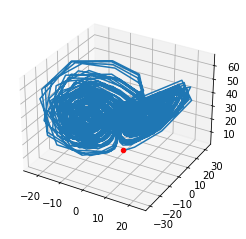

In [118]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*w0, c="red")
ax.plot(*result_ivp.y)

## The Euler method

unstable.

In [125]:
def florenz_nn(x):
    return nn.predict(x[None,]).ravel()

w_nn_eul = np.zeros([nstop+1, w0.size])
w_nn_eul[0] = w0
for n in range(nstop):
    w_nn_eul[n+1] = w_nn_eul[n] + dt * florenz_nn(w_nn_eul[n])

/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


ValueError: Input contains infinity or a value too large for dtype('float64').